In [1]:
import numpy as np
import random
import copy
from numba import jit
import time
import cProfile

In [162]:
class World:
    """
    The World class encapsulates information about the computational domain.
    
    Attributes
    ----------
    <to be written later>
    ----------
    
    """
    
    def __init__(self, ni, nj, nk):
        """
        Initializes the World object with the grid parameters

        Parameters
        ----------
        ni : int
            number of grid points along x coordinate
        nj : int
            number of grid points along y coordinate
        nk : int
            number of grid points along z coordinate
        ----------
        
        """
        
        self.ni = ni
        self.nj = nj
        self.nk = nk
        
        self.nn = np.zeros(3)
        
        self.nn[0] = self.ni
        self.nn[1] = self.nj
        self.nn[2] = self.nk
        
        self.x0 = np.zeros(3)
        self.dh = np.zeros(3)
        self.xm = np.zeros(3)
        self.xc = np.zeros(3)
        
        self.EPS_0 = 8.85418782e-12
        self.QE    = 1.602176565e-19;
        self.AMU   = 1.660538921e-27
        self.ME    = 9.10938215e-31;
        self.K     = 1.380648e-23;
        self.EvToK = self.QE/self.K;
        
        self.phi        = np.zeros((self.ni, self.nj, self.nk))
        self.object_id  = np.zeros((self.ni, self.nj, self.nk))
        self.phi_new    = np.zeros((self.ni, self.nj, self.nk))
        self.R          = np.zeros((self.ni, self.nj, self.nk))
        self.rho        = np.zeros((self.ni, self.nj, self.nk))
        self.node_vol   = np.zeros((self.ni, self.nj, self.nk))
        self.ef         = np.zeros((self.ni, self.nj, self.nk, 3))
    
    def setTime(self, dt, num_ts):
        self.dt     = dt
        self.num_ts = num_ts
        
    def setExtents(self, x1, y1, z1, x2, y2, z2):
        
        """
        Set mesh extents and compute grid spacing.

        Parameters
        ----------
        x1 : float
            x-coordinate of world origin
        y1 : float
            y-coordinate of world origin
        z1 : float
            z-coordinate of world origin
        x2 : float
            x-coordinate of world max bound
        y2 : float
            y-coordinate of world max bound
        z2 : float
            z-coordinate of world max bound
        ----------
        
        """
        
        self.x0[0] = x1
        self.x0[1] = y1
        self.x0[2] = z1
        
        self.xm[0] = x2
        self.xm[1] = y2
        self.xm[2] = z2
        
        for i in range(3):
            self.dh[i] = (self.xm[i] - self.x0[i]) / (self.nn[i] - 1)
            self.xc[i] = 0.5*(self.x0[i] + self.xm[i]) 
        
        self.computeNodeVolumes()
        
    def addSphere(self, sphere_x0, sphere_radius, sphere_phi):
            self.sphere_x0     = sphere_x0
            self.sphere_radius = sphere_radius
            self.sphere_radius2= sphere_radius**2
            self.sphere_phi    = sphere_phi
            
            for i in np.arange(0, self.ni):
                for j in np.arange(0, self.nj):
                    for k in np.arange(0, self.nk):
                        x = self.pos(np.array([i,j,k]))
                        if self.inSphere(x):
                            self.object_id[i,j,k] = 1
                            self.phi[i,j,k] = self.sphere_phi
                        elif i==0 or i ==self.ni-1 or \
                           j==0 or j ==self.nj-1 or \
                           k==0 or k ==self.nk-1:
                            self.object_id[i,j,k] = 3
                            
    
    def addInlet(self, phi_inlet):
        self.phi_inlet = phi_inlet
        
        for i in np.arange(0, self.ni):
                for j in np.arange(0, self.nj):
                    self.object_id[i,j,0] = 2
                    self.phi[i,j,0]       = 0
                                       
    
    def computeDebyeLength(self, Te, ne):
        """
        Compute the Debye length.

        Parameters
        ----------
        Te : float
            electron temperature, K
        ne : float
            number density, m3
        ----------
        
        """
        
        return np.sqrt(self.EPS_0*self.K*Te/(ne*self.QE**2))
    
    def potentialSolver6(self, w, max_it, tol):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # Step 1: create *integer* array the same size as u 
        x = np.zeros_like(self.phi,dtype=np.int)

        # Step 2: populate all non-boundary cells with running numbers from 1 to (n-2)^2
        x[1:-1,1:-1,1:-1] = np.arange(1,(self.ni-2)*(self.nj-2)*(self.nk-2)+1).reshape(self.ni-2,self.nj-2,self.nk-2)

        # Step 3: get indices of even (red) and odd (black) points
        ir, jr, kr = np.where((x>0) & (x%2 == 0)) # indices of red pts = indices of even numbers
        ib, jb, kb = np.where((x>0) & (x%2 == 1)) # indices of black pts = indices of odd numbers

        # solve potential
        for it in np.arange(1,max_it+1):
            """
            for i in np.arange(1,self.ni-1):
                for j in np.arange(1,self.nj-1):
                    for k in np.arange(1,self.nk-1):
            """            
            """
            #standard internal open node
                        phi_new = (self.rho[i][j][k]/self.EPS_0 +\
                                        dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                        dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                        dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1]))/(2*dx2+2*dy2+2*dz2)
                                        
            # sucessive over relaxation  
                        self.phi[i,j,k] = self.phi[i,j,k] + 1.4*(phi_new - self.phi[i][j][k])
        
            """ 
            
            """
            #standard internal open node
            self.phi[1:self.ni-1,1:self.nj-1,1:self.nk-1] = \
                            (self.rho[1:self.ni-1,1:self.nj-1,1:self.nk-1]/self.EPS_0 +\
                            dx2*(self.phi[0:self.ni-2,1:self.nj-1,1:self.nk-1] + self.phi[2:self.ni,1:self.nj-1,1:self.nk-1])+\
                            dy2*(self.phi[1:self.ni-1,0:self.nj-2,1:self.nk-1] + self.phi[1:self.ni-1,2:self.nj,1:self.nk-1])+\
                            dz2*(self.phi[1:self.ni-1,1:self.nj-1,0:self.nk-2] + self.phi[1:self.ni-1,1:self.nj-1,2:self.nk]))/(2*dx2+2*dy2+2*dz2)
            
            """
            """
            # Red point update
            self.phi[ir,jr,kr] = (1-w)*self.phi[ir,jr,kr] + (1.0/6.0)*w*(self.phi[ir+1,jr,kr] + self.phi[ir-1,jr,kr] +\
                                                                    self.phi[ir,jr+1,kr] + self.phi[ir,jr-1,kr] +\
                                                                    self.phi[ir,jr,kr+1] + self.phi[ir,jr,kr-1] +\
                                                                    (self.rho[ir,jr,kr]/self.EPS_0)*(self.dh[0]*self.dh[1]))

            # Black point update
            self.phi[ib,jb,kb] = (1-w)*self.phi[ib,jb,kb] + (1.0/6.0)*w*(self.phi[ib+1,jb,kb] + self.phi[ib-1,jb,kb] +\
                                                                    self.phi[ib,jb+1,kb] + self.phi[ib,jb-1,kb] +\
                                                                    self.phi[ib,jb,kb+1] + self.phi[ib,jb,kb-1] +\
                                                                    (self.rho[ib,jb,kb]/self.EPS_0)*(self.dh[0]*self.dh[1]))
            """
            
            # Red point update
            self.phi[ir,jr,kr] = (1-w)*self.phi[ir,jr,kr] + w*((self.phi[ir+1,jr,kr] + self.phi[ir-1,jr,kr])*dx2 +\
                                                                         (self.phi[ir,jr+1,kr] + self.phi[ir,jr-1,kr])*dy2 +\
                                                                         (self.phi[ir,jr,kr+1] + self.phi[ir,jr,kr-1])*dz2 +\
                                                                         (self.rho[ir,jr,kr]/self.EPS_0))/(2*dx2+2*dy2+2*dz2)

            # Black point update
            self.phi[ib,jb,kb] = (1-w)*self.phi[ib,jb,kb] + w*((self.phi[ib+1,jb,kb] + self.phi[ib-1,jb,kb])*dx2 +\
                                                                         (self.phi[ib,jb+1,kb] + self.phi[ib,jb-1,kb])*dy2 +\
                                                                         (self.phi[ib,jb,kb+1] + self.phi[ib,jb,kb-1])*dz2 +\
                                                                         (self.rho[ib,jb,kb]/self.EPS_0))/(2*dx2+2*dy2+2*dz2)
           
            #check for convergence*/
            if it%25==0:
                sum = 0;
                """
                for i in np.arange(1,self.ni-1):
                    for j in np.arange(1,self.nj-1):
                        for k in np.arange(1,self.nk-1):
                """

                self.R[1:self.ni-1,1:self.nj-1,1:self.nk-1] = \
                -self.phi[1:self.ni-1,1:self.nj-1,1:self.nk-1]*(2*dx2+2*dy2+2*dz2) +\
                self.rho[1:self.ni-1,1:self.nj-1,1:self.nk-1]/self.EPS_0 +\
                dx2*(self.phi[0:self.ni-2,1:self.nj-1,1:self.nk-1] + self.phi[2:self.ni,1:self.nj-1,1:self.nk-1]) +\
                dy2*(self.phi[1:self.ni-1,0:self.nj-2,1:self.nk-1] + self.phi[1:self.ni-1,2:self.nj,1:self.nk-1]) +\
                dz2*(self.phi[1:self.ni-1,1:self.nj-1,0:self.nk-2] + self.phi[1:self.ni-1,1:self.nj-1,2:self.nk])

                sum = np.sum(self.R**2)

                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                #print("iter: "+str(it)+", L2 = "+str(L2))
                if (L2<tol):
                    converged = True
                    break

        #if (converged==False):
        #    print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    def potentialSolver7(self, w, max_it, tol, n0, phi0, Te0):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # solve potential
        for it in np.arange(1,max_it+1):
            for i in np.arange(0,self.ni):
                for j in np.arange(0,self.nj):
                    for k in np.arange(0,self.nk):
                        if self.object_id[i,j,k] > 0 :
                            # skip over solid (fixed) nodes
                            continue
                        if (i==0):
                            self.phi[i,j,k] = self.phi[i+1,j,k]
                        elif (i==self.ni-1):
                            self.phi[i,j,k] = self.phi[i-1,j,k]
                        elif (j==0):
                            self.phi[i,j,k] = self.phi[i,j+1,k]
                        elif (j==self.nj-1):
                            self.phi[i,j,k] = self.phi[i,j-1,k]
                        elif (k==0):
                            self.phi[i,j,k] = self.phi[i,j,k+1]
                        elif (k==self.nk-1):
                            self.phi[i,j,k] = self.phi[i,j,k-1]
                        else:
                            # standard internal node
                            ne = n0*np.exp((self.phi[i][j][k]-phi0)/Te0)
                            
                            self.phi[i][j][k] = ((self.rho[i][j][k]-self.QE*ne)/self.EPS_0 +
                                        dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +
                                        dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +
                                        dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1]))/(2*dx2+2*dy2+2*dz2)
                            
                            # SOR
                            #self.phi[i][j][k] = self.phi[i][j][k] + w*(phi_new-self.phi[i][j][k])
                            
                            
            #check for convergence*/
            if it%25==0:
                sum = 0;
                for i in np.arange(0,self.ni):
                    for j in np.arange(0,self.nj):
                        for k in np.arange(0,self.nk):
                            if self.object_id[i,j,k] > 0 :
                                # skip over solid (fixed) nodes
                                continue
                            
                            R = 0.0
                            
                            if (i==0):
                                R = self.phi[i,j,k] - self.phi[i+1,j,k]
                            elif (i==self.ni-1):
                                R = self.phi[i,j,k] - self.phi[i-1,j,k]
                            elif (j==0):
                                R = self.phi[i,j,k] - self.phi[i,j+1,k]
                            elif (j==self.nj-1):
                                R = self.phi[i,j,k] - self.phi[i,j-1,k]
                            elif (k==0):
                                R = self.phi[i,j,k] - self.phi[i,j,k+1]
                            elif (k==self.nk-1):
                                R = self.phi[i,j,k] - self.phi[i,j,k-1]
                            
                            else:
                                ne = n0*np.exp((self.phi[i][j][k]-phi0)/Te0)
 
                                R = -self.phi[i][j][k]*(2*dx2+2*dy2+2*dz2) +\
                                (self.rho[i][j][k]-self.QE*ne)/self.EPS_0 +\
                                dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1])

                            sum += R*R;


                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                print("iter: "+str(it)+", L2 = "+str(L2))
                if (L2<tol):
                    converged = True
                    break
                    
        if (converged==False):
            print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    
    def potentialSolver8(self, w, max_it, tol, n0, phi0, Te0):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # solve potential
        #for it in np.arange(1,max_it+1):
        #    for i in np.arange(0,self.ni):
        #        for j in np.arange(0,self.nj):
        #            for k in np.arange(0,self.nk):
        #if self.object_id[i,j,k] > 0 :
        #    # skip over solid (fixed) nodes
        #    continue
        
        
        #if (i==0):
        #    self.phi[i,j,k] = self.phi[i+1,j,k]
        #elif (i==self.ni-1):
        #    self.phi[i,j,k] = self.phi[i-1,j,k]
        #elif (j==0):
        #    self.phi[i,j,k] = self.phi[i,j+1,k]
        #elif (j==self.nj-1):
        #    self.phi[i,j,k] = self.phi[i,j-1,k]
        #elif (k==0):
        #    self.phi[i,j,k] = self.phi[i,j,k+1]
        #elif (k==self.nk-1):
        #    self.phi[i,j,k] = self.phi[i,j,k-1]
        
        x    = np.where(self.object_id == 0)
        xarr = np.asarray(x)
        
        for it in np.arange(1,max_it+1):
        
            self.phi[0,:,:]         = self.phi[1,:,:]
            self.phi[self.ni-1,:,:] = self.phi[self.ni-2,:,:]

            self.phi[:,0,:]         = self.phi[:,1,:]
            self.phi[self.nj-1,:,:] = self.phi[:,self.nj-2,:]

            self.phi[:,:,0]         = self.phi[:,:,1]
            self.phi[:,:,self.nk-1] = self.phi[:,:,self.nk-2]

            # standard internal node
            ne = np.zeros(len(xarr[0,:]))
            
            ne = n0*np.exp((self.phi[xarr[0,:],xarr[1,:],xarr[2,:]]-phi0)/Te0)
            
            #phi_new = np.zeros(len(xarr[0,:]))

            self.phi[xarr[0,:],xarr[1,:],xarr[2,:]] = ((self.rho[xarr[0,:],xarr[1,:],xarr[2,:]]-self.QE*ne)/self.EPS_0 +
                        dx2*(self.phi[xarr[0,:]-1,xarr[1,:],xarr[2,:]] + self.phi[xarr[0,:]+1,xarr[1,:],xarr[2,:]]) +
                        dy2*(self.phi[xarr[0,:],xarr[1,:]-1,xarr[2,:]] + self.phi[xarr[0,:],xarr[1,:]+1,xarr[2,:]]) +
                        dz2*(self.phi[xarr[0,:],xarr[1,:],xarr[2,:]-1] + self.phi[xarr[0,:],xarr[1,:],xarr[2,:]+1]))/(2*dx2+2*dy2+2*dz2)

            
            """              
            #check for convergence*/
            if it%25==0:
                sum = 0;
                #for i in np.arange(0,self.ni):
                #    for j in np.arange(0,self.nj):
                #        for k in np.arange(0,self.nk):
                #            if self.object_id[i,j,k] > 0 :
                #                # skip over solid (fixed) nodes
                #                continue
                            

                
                self.R[0,:,:]         = self.phi[0,:,:] - self.phi[1,:,:]
                self.R[self.ni-1,:,:] = self.phi[self.ni-1,:,:] - self.phi[self.ni-2,:,:]
                
                self.R[:,0,:]         = self.phi[:,0,:] - self.phi[:,1,:]
                self.R[:,self.nj-1,:] = self.phi[:,self.nj-1,:] - self.phi[:,self.nj-2,:]
                
                self.R[:,:,0]         = self.phi[:,:,0] - self.phi[:,:,1]
                self.R[:,:,self.nk-1] = self.phi[:,:,self.nk-1] - self.phi[:,:,self.nk-2]


                ne = np.zeros(len(xarr[0,:]))
            
                ne = n0*np.exp((self.phi[xarr[0,:],xarr[1,:],xarr[2,:]]-phi0)/Te0)

                R1 = -self.phi[xarr[0,:],xarr[1,:],xarr[2,:]]*(2*dx2+2*dy2+2*dz2) +\
                (self.rho[xarr[0,:],xarr[1,:],xarr[2,:]]-self.QE*ne)/self.EPS_0 +\
                dx2*(self.phi[xarr[0,:]-1,xarr[1,:],xarr[2,:]] + self.phi[xarr[0,:]+1,xarr[1,:],xarr[2,:]]) +\
                dy2*(self.phi[xarr[0,:],xarr[1,:]-1,xarr[2,:]] + self.phi[xarr[0,:],xarr[1,:]+1,xarr[2,:]]) +\
                dz2*(self.phi[xarr[0,:],xarr[1,:],xarr[2,:]-1] + self.phi[xarr[0,:],xarr[1,:],xarr[2,:]+1])

                sum = np.sum(self.R**2) + np.sum(R1**2)
                """
            #check for convergence*/
            if it%25==0:
                sum = 0;
                for i in np.arange(0,self.ni):
                    for j in np.arange(0,self.nj):
                        for k in np.arange(0,self.nk):
                            if self.object_id[i,j,k] > 0 :
                                # skip over solid (fixed) nodes
                                continue
                            
                            R = 0.0
                            
                            if (i==0):
                                R = self.phi[i,j,k] - self.phi[i+1,j,k]
                            elif (i==self.ni-1):
                                R = self.phi[i,j,k] - self.phi[i-1,j,k]
                            elif (j==0):
                                R = self.phi[i,j,k] - self.phi[i,j+1,k]
                            elif (j==self.nj-1):
                                R = self.phi[i,j,k] - self.phi[i,j-1,k]
                            elif (k==0):
                                R = self.phi[i,j,k] - self.phi[i,j,k+1]
                            elif (k==self.nk-1):
                                R = self.phi[i,j,k] - self.phi[i,j,k-1]
                            
                            else:
                                ne = n0*np.exp((self.phi[i][j][k]-phi0)/Te0)
 
                                R = -self.phi[i][j][k]*(2*dx2+2*dy2+2*dz2) +\
                                (self.rho[i][j][k]-self.QE*ne)/self.EPS_0 +\
                                dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1])

                            sum += R*R;



                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                print("iter: "+str(it)+", L2 = "+str(L2))
                
                if (L2<tol):
                    converged = True
                    break
                    
        if (converged==False):
            print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    
    def efSolver(self):
        """
        Compute the electric field from potential function.

        Parameters
        ----------
        
        ----------
        
        """
        dx = self.dh[0] # dx
        dy = self.dh[1] # dy
        dz = self.dh[2] # dz
        
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):

                    #x-component#
                    if i==0: 
                        # forward
                        self.ef[i][j][k][0] = -(-3*self.phi[i][j][k]+\
                                               4*self.phi[i+1][j][k]-\
                                               self.phi[i+2][j][k])/(2*dx)
                    elif i==self.ni-1:  
                        # backward
                        self.ef[i][j][k][0] = -(self.phi[i-2][j][k]-\
                                               4*self.phi[i-1][j][k]+\
                                               3*self.phi[i][j][k])/(2*dx)
                    else: 
                        #central
                        self.ef[i][j][k][0] = -(self.phi[i+1][j][k] - \
                                                self.phi[i-1][j][k])/(2*dx)

                    #y-component
                    if j==0:
                        self.ef[i][j][k][1] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j+1][k]-\
                                                self.phi[i][j+2][k])/(2*dy)
                    elif j==self.nj-1:
                        self.ef[i][j][k][1] = -(self.phi[i][j-2][k] - \
                                                4*self.phi[i][j-1][k] +\
                                                3*self.phi[i][j][k])/(2*dy)
                    else:
                         self.ef[i][j][k][1] = -(self.phi[i][j+1][k] - \
                                                 self.phi[i][j-1][k])/(2*dy)

                    #z-component
                    if k==0:
                        self.ef[i][j][k][2] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j][k+1]-
                                                self.phi[i][j][k+2])/(2*dz)
                    elif k==self.nk-1:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k-2] - \
                                                4*self.phi[i][j][k-1]    + \
                                                3*self.phi[i][j][k])/(2*dz)
                    else:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k+1] - \
                                                self.phi[i][j][k-1])/(2*dz)
    
    def efSolver2(self):
        """
        Compute the electric field from potential function.

        Parameters
        ----------
        
        ----------
        
        """
        dx = self.dh[0] # dx
        dy = self.dh[1] # dy
        dz = self.dh[2] # dz
        
        """
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):
        """

        ##x-component#
        #if i==0: 
        #x-component#
        """
                    if i==0: 
                        # forward
                        self.ef[i][j][k][0] = -(-3*self.phi[i][j][k]+\
                                               4*self.phi[i+1][j][k]-\
                                               self.phi[i+2][j][k])/(2*dx)
        """
                    
        # forward
        self.ef[0,0:self.nj,0:self.nk,0] = -(-3*self.phi[0,0:self.nj,0:self.nk]+\
                               4*self.phi[1,0:self.nj,0:self.nk]-\
                               self.phi[2,0:self.nj,0:self.nk])/(2*dx)
        
        #elif i==self.ni-1:  
        """
        elif i==self.ni-1:  
                        # backward
                        self.ef[i][j][k][0] = -(self.phi[i-2][j][k]-\
                                               4*self.phi[i-1][j][k]+\
                                               3*self.phi[i][j][k])/(2*dx)
        """           
        # backward
        self.ef[self.ni-1,0:self.nj,0:self.nk,0] = -(self.phi[self.ni-3,0:self.nj,0:self.nk]-\
                                   4*self.phi[self.ni-2,0:self.nj,0:self.nk]+\
                                   3*self.phi[self.ni-1,0:self.nj,0:self.nk])/(2*dx)
        """
        else: 
            #central
            self.ef[i][j][k][0] = -(self.phi[i+1][j][k] - \
                                    self.phi[i-1][j][k])/(2*dx)
        """ 
        #central
        self.ef[1:self.ni-1,0:self.nj,0:self.nk,0] = -(self.phi[2:self.ni,0:self.nj,0:self.nk] - \
                                self.phi[0:self.ni-2,0:self.nj,0:self.nk])/(2*dx)


        #y-component
        #if j==0:
        """
        if j==0:
                        self.ef[i][j][k][1] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j+1][k]-\
                                                self.phi[i][j+2][k])/(2*dy)
                    
        """
        self.ef[0:self.ni,0,0:self.nk,1] = -(-3*self.phi[0:self.ni,0,0:self.nk] + \
                                    4*self.phi[0:self.ni,1,0:self.nk]-\
                                    self.phi[0:self.ni,2,0:self.nk])/(2*dy)
        #elif j==self.nj-1:
        """
        elif j==self.nj-1:
                        self.ef[i][j][k][1] = -(self.phi[i][j-2][k] - \
                                                4*self.phi[i][j-1][k] +\
                                                3*self.phi[i][j][k])/(2*dy)
                    
        """
        self.ef[0:self.ni,self.nj-1,0:self.nk,1] = -(self.phi[0:self.ni,self.nj-3,0:self.nk] - \
                                    4*self.phi[0:self.ni,self.nj-2,0:self.nk] +\
                                    3*self.phi[0:self.ni,self.nj-1,0:self.nk])/(2*dy)
        #else:
        """
        else:
                         self.ef[i][j][k][1] = -(self.phi[i][j+1][k] - \
                                                 self.phi[i][j-1][k])/(2*dy)

        """
        self.ef[0:self.ni,1:self.nj-1,0:self.nk,1] = -(self.phi[0:self.ni,2:self.nj,0:self.nk] - \
                                     self.phi[0:self.ni,0:self.nj-2,0:self.nk])/(2*dy)

        #z-component
        '''
        if k==0:
            self.ef[i][j][k][2] = -(-3*self.phi[i][j][k] + \
                                    4*self.phi[i][j][k+1]-
                                    self.phi[i][j][k+2])/(2*dz)
            
        '''
        #z-component
        #if k==0:
        self.ef[0:self.ni,0:self.nj,0,2] = -(-3*self.phi[0:self.ni,0:self.nj,0] + \
                                4*self.phi[0:self.ni,0:self.nj,1]-
                                self.phi[0:self.ni,0:self.nj,2])/(2*dz)

        """
        elif k==self.nk-1:
            self.ef[i][j][k][2] = -(self.phi[i][j][k-2] - \
                                    4*self.phi[i][j][k-1]    + \
                                    3*self.phi[i][j][k])/(2*dz)
        """
        
        #elif k==self.nk-1:
        self.ef[0:self.ni,0:self.nj,self.nk-1,2] = -(self.phi[0:self.ni,0:self.nj,self.nk-3] - \
                                    4*self.phi[0:self.ni,0:self.nj,self.nk-2]    + \
                                    3*self.phi[0:self.ni,0:self.nj,self.nk-1])/(2*dz) 
        """
        else:
            self.ef[i][j][k][2] = -(self.phi[i][j][k+1] - \
                                    self.phi[i][j][k-1])/(2*dz)
        """
        #else:
        self.ef[0:self.ni,0:self.nj,1:self.nk-1,2] = -(self.phi[0:self.ni,0:self.nj,2:self.nk] - \
                                    self.phi[0:self.ni,0:self.nj,0:self.nk-2])/(2*dz)
        
        
    def computeNodeVolumes(self): 
        """
        Compute the node volumes.
        Parameters
        ----------
        
        ----------
        
        """
        for i in np.arange(0,self.ni):
            for j in np.arange(0,self.nj):
                for k in np.arange(0,self.nk):
        
                    V = self.dh[0]*self.dh[1]*self.dh[2]
                    if (i==0 or i==self.ni-1): V*=0.5
                    if (j==0 or j==self.nj-1): V*=0.5
                    if (k==0 or k==self.nk-1): V*=0.5
                    
                    self.node_vol[i][j][k] = V
                    
    def XtoL(self, x):
        """
        Determine which cell a particle at position vector 
        x belongs to.
        
        Parameters
        ----------
        x : numpy.ndarray
            position vector 
        ----------
        """
        lc = np.zeros(3)
        
        lc[0] = (x[0]-self.x0[0])/self.dh[0];
        lc[1] = (x[1]-self.x0[1])/self.dh[1];
        lc[2] = (x[2]-self.x0[2])/self.dh[2];
        
        return lc
    
    def pos(self, lc):
        """
        Determine which position from logical coordinate
        
        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        x = np.zeros(3)
        
        x[0] = self.x0[0] + self.dh[0]*lc[0]
        x[1] = self.x0[1] + self.dh[1]*lc[1]
        x[2] = self.x0[2] + self.dh[2]*lc[2];
        
        return x
    
    def inSphere(self, x):
        """
        Determine which position from logical coordinate
        
        Parameters
        ----------
        x_vec : numpy.ndarray
            position vector vector x_vec[0] = (x1[0], x1[1], x1[2])
        ----------
        """
        
        r  = x - self.sphere_x0
        r2 = r[0]*r[0] + r[1]*r[1] + r[2]*r[2]
        
        if r2 <= self.sphere_radius2:
            return True
        else:
            return False
        
        
    
    def XtoLvec(self, x_vec):
        """
        Determine which cell a particle at position vector 
        x belongs to.
        
        Parameters
        ----------
        x_vec : numpy.ndarray
            position vector vector x_vec[0] = (x1[0], x1[1], x1[2])
        ----------
        """
        lc = np.zeros((len(x_vec[:,0]),3))
        
        lc[:,0] = (x_vec[:,0]-self.x0[0])/self.dh[0];
        lc[:,1] = (x_vec[:,1]-self.x0[1])/self.dh[1];
        lc[:,2] = (x_vec[:,2]-self.x0[2])/self.dh[2];
        
        return lc
    
    def addSpeciesList(self, speciesList):
        self.speciesList = speciesList
    
    def computeChargeDensity(self):
        """
        Compute the charge density.
        
        Parameters
        ----------
     
        ----------
        """
        
        self.rho = np.zeros((self.ni, self.nj, self.nk))
        
        for species in self.speciesList:
            if species.charge!=0:
                self.rho += species.charge*species.den         

In [107]:
x = np.where(world.object_id == 0 )

In [106]:
world.phi[x]

array([ -6.67185298, -13.32027503, -19.92040626, ..., -93.00072716,
       -93.00207395, -93.00207395])

In [157]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.potentialSolver7(0.0, 10000, 1E-3, 0.0, 1.5, 1E12)

iter: 25, L2 = 6363.147279084832
iter: 50, L2 = 2227.8783311452835
iter: 75, L2 = 937.5741249002374
iter: 100, L2 = 432.5592234142009


KeyboardInterrupt: 

In [163]:
world=World(21,21,41)
world.setTime(1E-7,400)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.4)

world.addSphere(np.array([0.0,0.0,0.15]), 0.05, -100.0)
world.addInlet(0.0)
world.potentialSolver8(1.4, 10000, 1E-3, 0.0, 1.5, 1E12)

iter: 25, L2 = 13454.336816243396
iter: 50, L2 = 8176.262420875224
iter: 75, L2 = 6019.516289155582
iter: 100, L2 = 4810.847601344983
iter: 125, L2 = 4025.5122565700867
iter: 150, L2 = 3463.738995474129
iter: 175, L2 = 3033.7281889158403
iter: 200, L2 = 2688.425278301499
iter: 225, L2 = 2401.6796915033474
iter: 250, L2 = 2157.907608005113
iter: 275, L2 = 1947.206768248013
iter: 300, L2 = 1762.9044112589063
iter: 325, L2 = 1600.2647739380534
iter: 350, L2 = 1455.7761622984744
iter: 375, L2 = 1326.7394510519414
iter: 400, L2 = 1211.0194113491611
iter: 425, L2 = 1106.8874923603955
iter: 450, L2 = 1012.9181088058157
iter: 475, L2 = 927.9175630597726
iter: 500, L2 = 850.8736978485601
iter: 525, L2 = 780.9192222178443
iter: 550, L2 = 717.304360973564
iter: 575, L2 = 659.3760438027838
iter: 600, L2 = 606.561791326391
iter: 625, L2 = 558.357041611805
iter: 650, L2 = 514.3150393902438
iter: 675, L2 = 474.0386622237542
iter: 700, L2 = 437.17373029083404
iter: 725, L2 = 403.4034667999766
iter: 75

True

In [114]:
np.shape(np.where(world.object_id == 0))

(3, 13565)

In [115]:
np.shape(np.where(world.object_id == 1))

(3, 514)

In [116]:
np.shape(np.where(world.object_id == 2))

(3, 441)

In [117]:
np.shape(np.where(world.object_id == 3))

(3, 3561)

In [121]:
world.phi[np.where(world.object_id == 1)] = world.phi[np.where(world.object_id == 1)]*2

In [149]:
x = np.where(world.object_id == 0)

In [144]:
xarr = np.asarray(x)

In [146]:
len(xarr[0,:])

13565

In [140]:
world.phi[xarr[0,:],xarr[1,:],xarr[2,:]] = world.phi[xarr[0,:]-1,xarr[1,:],xarr[2,:]]

In [151]:
np.shape(world.phi[xarr[0,:],xarr[1,:],xarr[2,:]])

(13565,)

In [ ]:
class Particle:
    """
    The Particle class encapsulates information about the particles 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    
    def __init__(self, pos, vel, mpw):
        """
        Initializes the Particle object with the position, 
        speed, and macrparticle weight.

        Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        
        self.pos = pos
        self.vel = vel
        self.mpw = mpw
        

class Species:
    """
    The Species class encapsulates information about the species 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    def __init__(self, name, mass, charge, worldObj):
        """
        Initializes the Species object with the name, mass,
        charge.

        Parameters
        ----------
        name : str
            species name
        mass : float
            species mass
        charge : float
            species charge
        mpw : float
            macroparticle weight  
        ----------

        """
        
        self.particleList = []
        
        self.name   = name
        self.mass   = mass
        self.charge = charge
        
        self.den    = np.zeros((worldObj.ni, worldObj.nj, worldObj.nk))
        
        self.worldObj = worldObj
    
    def addParticle(self, pos, vel, mpw):
        """random.random()
        add a particle to particleList

         Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoL(pos)

        #electric field at particle position
        ef_part = self.gather_ef(lc)

        #rewind velocity back by 0.5*dt*ef
        vel -=  self.charge/self.mass*ef_part*(0.5*self.worldObj.dt);
        
        #add particle to list
        self.particleList.append(Particle(pos, vel, mpw))
        
        
    def loadParticlesBox(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : number of macroparticles
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        mpw      = num_real/num_mp;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw

        #load particles on an equally spaced grid
        for p in np.arange(0,num_mp+1):
            # sample random position
            pos = np.zeros(3)
            vel = np.zeros(3)

            #rnd = random.random()

            pos[0] = x1[0] + random.random()*(x2[0]-x1[0]);
            pos[1] = x1[1] + random.random()*(x2[1]-x1[1]);
            pos[2] = x1[2] + random.random()*(x2[2]-x1[2]);

            #set initial velocity
            vel[0] = 0.0
            vel[1] = 0.0
            vel[2] = 0.0

            self.addParticle(pos,vel,mpw); # add new particle
            
    def loadParticlesBoxQS(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : numpy.ndarray
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        num_mp_tot = (num_mp[0]-1)*(num_mp[1]-1)*(num_mp[2]-1)
        mpw      = num_real/num_mp_tot;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw
        
        di = (x2[0]-x1[0])/(num_mp[0]-1);
        dj = (x2[1]-x1[1])/(num_mp[1]-1);
        dk = (x2[2]-x1[2])/(num_mp[2]-1);

        #load particles on a equally spaced grid
        
        for i in np.arange(0,num_mp[0]):
            for j in np.arange(0,num_mp[1]):
                for k in np.arange(0,num_mp[2]):
                    
                    # sample random position
                    pos = np.zeros(3)
                    vel = np.zeros(3)
                    
                    pos[0] = x1[0] + i*di;
                    pos[1] = x1[1] + j*dj;
                    pos[2] = x1[2] + k*dk;

                    # shift particles on max faces back to the domain
                    if (pos[0]==x2[0]): pos[0]-=1e-4*di;
                    if (pos[1]==x2[1]): pos[1]-=1e-4*dj;
                    if (pos[2]==x2[2]): pos[2]-=1e-4*dk;

                    w = 1;
                    if (i==0 or i==num_mp[0]-1): w*=0.5
                    if (j==0 or j==num_mp[1]-1): w*=0.5
                    if (k==0 or k==num_mp[2]-1): w*=0.5

                    #set initial velocity
                    vel[0] = 0.0
                    vel[1] = 0.0
                    vel[2] = 0.0

                    self.addParticle(pos,vel,mpw*w)
                    
    
    def scatter_den(self, lc, value):
        """
        scatters scalar value onto a field at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        self.den[i][j][k]      += value*(1-di)*(1-dj)*(1-dk)
        self.den[i+1][j][k]    += value*(di)*(1-dj)*(1-dk)
        self.den[i+1][j+1][k]  += value*(di)*(dj)*(1-dk)
        self.den[i][j+1][k]    += value*(1-di)*(dj)*(1-dk)
        self.den[i][j][k+1]    += value*(1-di)*(1-dj)*(dk)
        self.den[i+1][j][k+1]  += value*(di)*(1-dj)*(dk)
        self.den[i+1][j+1][k+1]+= value*(di)*(dj)*(dk)
        self.den[i][j+1][k+1]  += value*(1-di)*(dj)*(dk)
    
    
    def scatter_den2(self, lc, value):
        """
        scatters scalar value onto a field at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        
        
        if lc [:,0].any() < 0 or \
             lc [:,0].any() >=self.worldObj.ni-1 or \
             lc [:,1].any() < 0 or \
             lc [:,1].any() >=self.worldObj.nj-1 or \
             lc [:,2].any() < 0 or \
             lc [:,2].any() >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = lc[:,0].astype(int)
        di = lc[:,0]-i

        j  = lc[:,1].astype(int)
        dj = lc[:,1]-j

        k  = lc[:,2].astype(int)
        dk = lc[:,2]-k
        
        self.den2 = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk, len(self.particleList)), np.dtype('f4')) 
        
        self.den2[i,j,k,:]      = value*(1-di)*(1-dj)*(1-dk)
        self.den2[i+1,j,k,:]    = value*(di)*(1-dj)*(1-dk)
        self.den2[i+1,j+1,k,:]  = value*(di)*(dj)*(1-dk)
        self.den2[i,j+1,k,:]    = value*(1-di)*(dj)*(1-dk)
        self.den2[i,j,k+1,:]    = value*(1-di)*(1-dj)*(dk)
        self.den2[i+1,j,k+1,:]  = value*(di)*(1-dj)*(dk)
        self.den2[i+1,j+1,k+1,:]= value*(di)*(dj)*(dk)
        self.den2[i,j+1,k+1,:]  = value*(1-di)*(dj)*(dk)
        
        for i in np.arange(0, self.worldObj.ni):
            for j in np.arange(0, self.worldObj.nj):
                for k in np.arange(0, self.worldObj.nk):
                    self.den[i,j,k] = np.sum(self.den2[i,j,k][:])
        
        
    
    
    def computeNumberDensity(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        for particle in self.particleList:
            lc = self.worldObj.XtoL(particle.pos)
            self.scatter_den(lc, self.mpw)
            
        self.den = self.den / self.worldObj.node_vol
    
    def computeNumberDensity3(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        #for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)
        
        for i in range(len(self.particleList)):
            self.scatter_den(lc[i,:], self.mpw)
            
        self.den = self.den / self.worldObj.node_vol
    
    
    def computeNumberDensity4(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        pos_vec2 = np.zeros((len(self.particleList),3))
        
        #for i in range(len(self.particleList)):
        #    pos_vec[i,:] = (self.particleList[i]).pos
        
        pos_vec2 = [(species1.particleList[i]).pos for i in range(len(species1.particleList))]
        
        pos_vec = np.asarray(pos_vec2)

        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)
        
        for i in range(len(self.particleList)):
            self.scatter_den(lc[i,:], self.mpw)
            
        self.den = self.den / self.worldObj.node_vol

    
    def computeNumberDensity2(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        #for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        self.scatter_den2(lc, self.mpw)

        self.den = self.den / self.worldObj.node_vol
        
    
    def gather_ef(self, lc):
        """
        gathers field value at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        data : numpy.ndarray
            electric field array
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        # gather electric field onto particle position
         
        ef_x  = self.worldObj.ef[i][j][k][0]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][0]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][0]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][0]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][0]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][0]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][0]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][0]*(1-di)*(dj)*(dk)
        
        ef_y  = self.worldObj.ef[i][j][k][1]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][1]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][1]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][1]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][1]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][1]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][1]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][1]*(1-di)*(dj)*(dk)
        
        ef_z  = self.worldObj.ef[i][j][k][2]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][2]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][2]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][2]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][2]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][2]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][2]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][2]*(1-di)*(dj)*(dk)
        
        ef_part = np.array([ef_x, ef_y, ef_z])
        
        return ef_part
    
    def gather_ef2(self, lc):
        """
        gathers field value at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        data : numpy.ndarray
            electric field array
        ----------
        """
        
        if lc [:,0].any() < 0 or \
             lc [:,0].any() >=self.worldObj.ni-1 or \
             lc [:,1].any() < 0 or \
             lc [:,1].any() >=self.worldObj.nj-1 or \
             lc [:,2].any() < 0 or \
             lc [:,2].any() >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = lc[:,0].astype(int)
        di = lc[:,0]-i

        j  = lc[:,1].astype(int)
        dj = lc[:,1]-j

        k  = lc[:,2].astype(int)
        dk = lc[:,2]-k

        # gather electric field onto particle position
        
        ef = np.zeros((len(lc[:,0]),3))
        
        ef[:,0]  = self.worldObj.ef[i,j,k][:,0]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,0]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,0]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,0]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,0]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,0]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,0]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,0]*(1-di)*(dj)*(dk)
        
        ef[:,1]  = self.worldObj.ef[i,j,k][:,1]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,1]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,1]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,1]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,1]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,1]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,1]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,1]*(1-di)*(dj)*(dk)
        
        ef[:,2]  = self.worldObj.ef[i,j,k][:,2]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j,k][:,2]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1,j+1,k][:,2]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j+1,k][:,2]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i,j,k+1][:,2]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j,k+1][:,2]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1,j+1,k+1][:,2]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i,j+1,k+1][:,2]*(1-di)*(dj)*(dk)
        
        
        return ef
    
    
    def advance(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        for particle in self.particleList:
        
            #get logical coordinate of particle's position
            lc = self.worldObj.XtoL(particle.pos)

            #electric field at particle position
            ef_part = self.gather_ef(lc)

            #update velocity from F=qE
            particle.vel += ef_part*(dt*self.charge/self.mass)

            #update position from v=dx/dt
            particle.pos += particle.vel*dt

            #did this particle leave the domain? reflect back
            for i in np.arange(3):
            
                if particle.pos[i] < x0[i]:
                    particle.pos[i]=2*x0[i]-particle.pos[i]
                    particle.vel[i]*=-1.0
                    
                elif particle.pos[i] >= xm[i]:
                    particle.pos[i]=2*xm[i]-particle.pos[i]
                    particle.vel[i]*=-1.0
                    
    def advance2(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        # for particle in self.particleList:
        
        pos_vec = np.zeros((len(self.particleList),3))
        
        for i in range(len(self.particleList)):
            pos_vec[i,:] = (self.particleList[i]).pos
        
        
        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        #electric field at particle position
        ef = self.gather_ef2(lc)

        #update velocity from F=qE
        for i in range(len(self.particleList)):
            self.particleList[i].vel += ef[i,:]*(dt*self.charge/self.mass)
        
        #update position from v=dx/dt
        for i in range(len(self.particleList)):
            self.particleList[i].pos += self.particleList[i].vel*dt
        
        #did this particle leave the domain? reflect back
        for particle in self.particleList:
            for i in np.arange(3):

                if particle.pos[i] < x0[i]:
                    particle.pos[i]=2*x0[i]-particle.pos[i]
                    particle.vel[i]*=-1.0

                elif particle.pos[i] >= xm[i]:
                    particle.pos[i]=2*xm[i]-particle.pos[i]
                    particle.vel[i]*=-1.0
                    
    def advance3(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        # for particle in self.particleList:
        
        pos_vec2 = np.zeros((len(self.particleList),3))
        
        #for i in range(len(self.particleList)):
        #    pos_vec[i,:] = (self.particleList[i]).pos
        
        pos_vec2 = [(species1.particleList[i]).pos for i in range(len(species1.particleList))]
        
        pos_vec = np.asarray(pos_vec2)

        
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoLvec(pos_vec)

        #electric field at particle position
        ef = self.gather_ef2(lc)

        #update velocity from F=qE
        for i in range(len(self.particleList)):
            self.particleList[i].vel += ef[i,:]*(dt*self.charge/self.mass)
        
        #update position from v=dx/dt
        for i in range(len(self.particleList)):
            self.particleList[i].pos += self.particleList[i].vel*dt
        
        #did this particle leave the domain? reflect back
        for particle in self.particleList:
            for i in np.arange(3):

                if particle.pos[i] < x0[i]:
                    particle.pos[i]=2*x0[i]-particle.pos[i]
                    particle.vel[i]*=-1.0

                elif particle.pos[i] >= xm[i]:
                    particle.pos[i]=2*xm[i]-particle.pos[i]
                    particle.vel[i]*=-1.0

In [4]:
world3=World(21,21,21)
world3.setTime(2E-10,100)
world3.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.2)

species1 = Species("O+", 16*world3.AMU, world3.QE, world3)
species2 = Species("e-", world3.ME, -1.0*world3.QE, world3)

world3.addSpeciesList([species1,species2])

species1.loadParticlesBoxQS(world3.x0, world3.xm, 1E11, [41,41,41])
species2.loadParticlesBoxQS(world3.x0, world3.xc, 1E11, [21,21,21])

species1.computeNumberDensity()
species2.computeNumberDensity()

world3.computeChargeDensity()

world3.potentialSolver6(1.7,10000, 1E-3)

world3.efSolver2()

start2 = time.clock()

for i in range(1,501):
    species1.advance2()
    species2.advance2()

    species1.computeNumberDensity3()
    species2.computeNumberDensity3()

    world3.computeChargeDensity()

    world3.potentialSolver6(1.7, 10000, 1E-4)

    world3.efSolver2()

    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList))+", ne-: "+str(len(species2.particleList)))

    if i==1 or i%100==0:

        x_arr1 = np.zeros(len(species1.particleList))
        y_arr1 = np.zeros(len(species1.particleList))
        z_arr1 = np.zeros(len(species1.particleList))

        x_arr2 = np.zeros(len(species2.particleList))
        y_arr2 = np.zeros(len(species2.particleList))
        z_arr2 = np.zeros(len(species2.particleList))

        for j in np.arange(0,len(species1.particleList)):
            pos = species1.particleList[j].pos
            x_arr1[j] = pos[0]
            y_arr1[j] = pos[1]
            z_arr1[j] = pos[2]

        for j in np.arange(0,len(species2.particleList)):
            pos = species2.particleList[j].pos
            x_arr2[j] = pos[0]
            y_arr2[j] = pos[1]
            z_arr2[j] = pos[2]

        np.savetxt('08species_1_x_'+str(i).zfill(5)+'.txt', x_arr1, fmt='%1.4f')
        np.savetxt('08species_1_y_'+str(i).zfill(5)+'.txt', y_arr1, fmt='%1.4f')
        np.savetxt('08species_1_z_'+str(i).zfill(5)+'.txt', z_arr1, fmt='%1.4f')

        np.savetxt('08species_2_x_'+str(i).zfill(5)+'.txt', x_arr2, fmt='%1.4f')
        np.savetxt('08species_2_y_'+str(i).zfill(5)+'.txt', y_arr2, fmt='%1.4f')
        np.savetxt('08species_2_z_'+str(i).zfill(5)+'.txt', z_arr2, fmt='%1.4f')

end2 = time.clock()
print("Time: "+str(end2-start2)+" seconds")

/home/athul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


ts = 1, nO+: 68921, ne-: 9261
ts = 2, nO+: 68921, ne-: 9261
ts = 3, nO+: 68921, ne-: 9261
ts = 4, nO+: 68921, ne-: 9261
ts = 5, nO+: 68921, ne-: 9261
ts = 6, nO+: 68921, ne-: 9261
ts = 7, nO+: 68921, ne-: 9261
ts = 8, nO+: 68921, ne-: 9261
ts = 9, nO+: 68921, ne-: 9261
ts = 10, nO+: 68921, ne-: 9261
ts = 11, nO+: 68921, ne-: 9261
ts = 12, nO+: 68921, ne-: 9261
ts = 13, nO+: 68921, ne-: 9261
ts = 14, nO+: 68921, ne-: 9261
ts = 15, nO+: 68921, ne-: 9261
ts = 16, nO+: 68921, ne-: 9261
ts = 17, nO+: 68921, ne-: 9261
ts = 18, nO+: 68921, ne-: 9261
ts = 19, nO+: 68921, ne-: 9261
ts = 20, nO+: 68921, ne-: 9261
ts = 21, nO+: 68921, ne-: 9261
ts = 22, nO+: 68921, ne-: 9261
ts = 23, nO+: 68921, ne-: 9261
ts = 24, nO+: 68921, ne-: 9261
ts = 25, nO+: 68921, ne-: 9261
ts = 26, nO+: 68921, ne-: 9261
ts = 27, nO+: 68921, ne-: 9261
ts = 28, nO+: 68921, ne-: 9261
ts = 29, nO+: 68921, ne-: 9261
ts = 30, nO+: 68921, ne-: 9261
ts = 31, nO+: 68921, ne-: 9261
ts = 32, nO+: 68921, ne-: 9261
ts = 33, nO+: 689

ts = 261, nO+: 68921, ne-: 9261
ts = 262, nO+: 68921, ne-: 9261
ts = 263, nO+: 68921, ne-: 9261
ts = 264, nO+: 68921, ne-: 9261
ts = 265, nO+: 68921, ne-: 9261
ts = 266, nO+: 68921, ne-: 9261
ts = 267, nO+: 68921, ne-: 9261
ts = 268, nO+: 68921, ne-: 9261
ts = 269, nO+: 68921, ne-: 9261
ts = 270, nO+: 68921, ne-: 9261
ts = 271, nO+: 68921, ne-: 9261
ts = 272, nO+: 68921, ne-: 9261
ts = 273, nO+: 68921, ne-: 9261
ts = 274, nO+: 68921, ne-: 9261
ts = 275, nO+: 68921, ne-: 9261
ts = 276, nO+: 68921, ne-: 9261
ts = 277, nO+: 68921, ne-: 9261
ts = 278, nO+: 68921, ne-: 9261
ts = 279, nO+: 68921, ne-: 9261
ts = 280, nO+: 68921, ne-: 9261
ts = 281, nO+: 68921, ne-: 9261
ts = 282, nO+: 68921, ne-: 9261
ts = 283, nO+: 68921, ne-: 9261
ts = 284, nO+: 68921, ne-: 9261
ts = 285, nO+: 68921, ne-: 9261
ts = 286, nO+: 68921, ne-: 9261
ts = 287, nO+: 68921, ne-: 9261
ts = 288, nO+: 68921, ne-: 9261
ts = 289, nO+: 68921, ne-: 9261
ts = 290, nO+: 68921, ne-: 9261
ts = 291, nO+: 68921, ne-: 9261
ts = 292

/home/athul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<IPython.core.display.Javascript object>


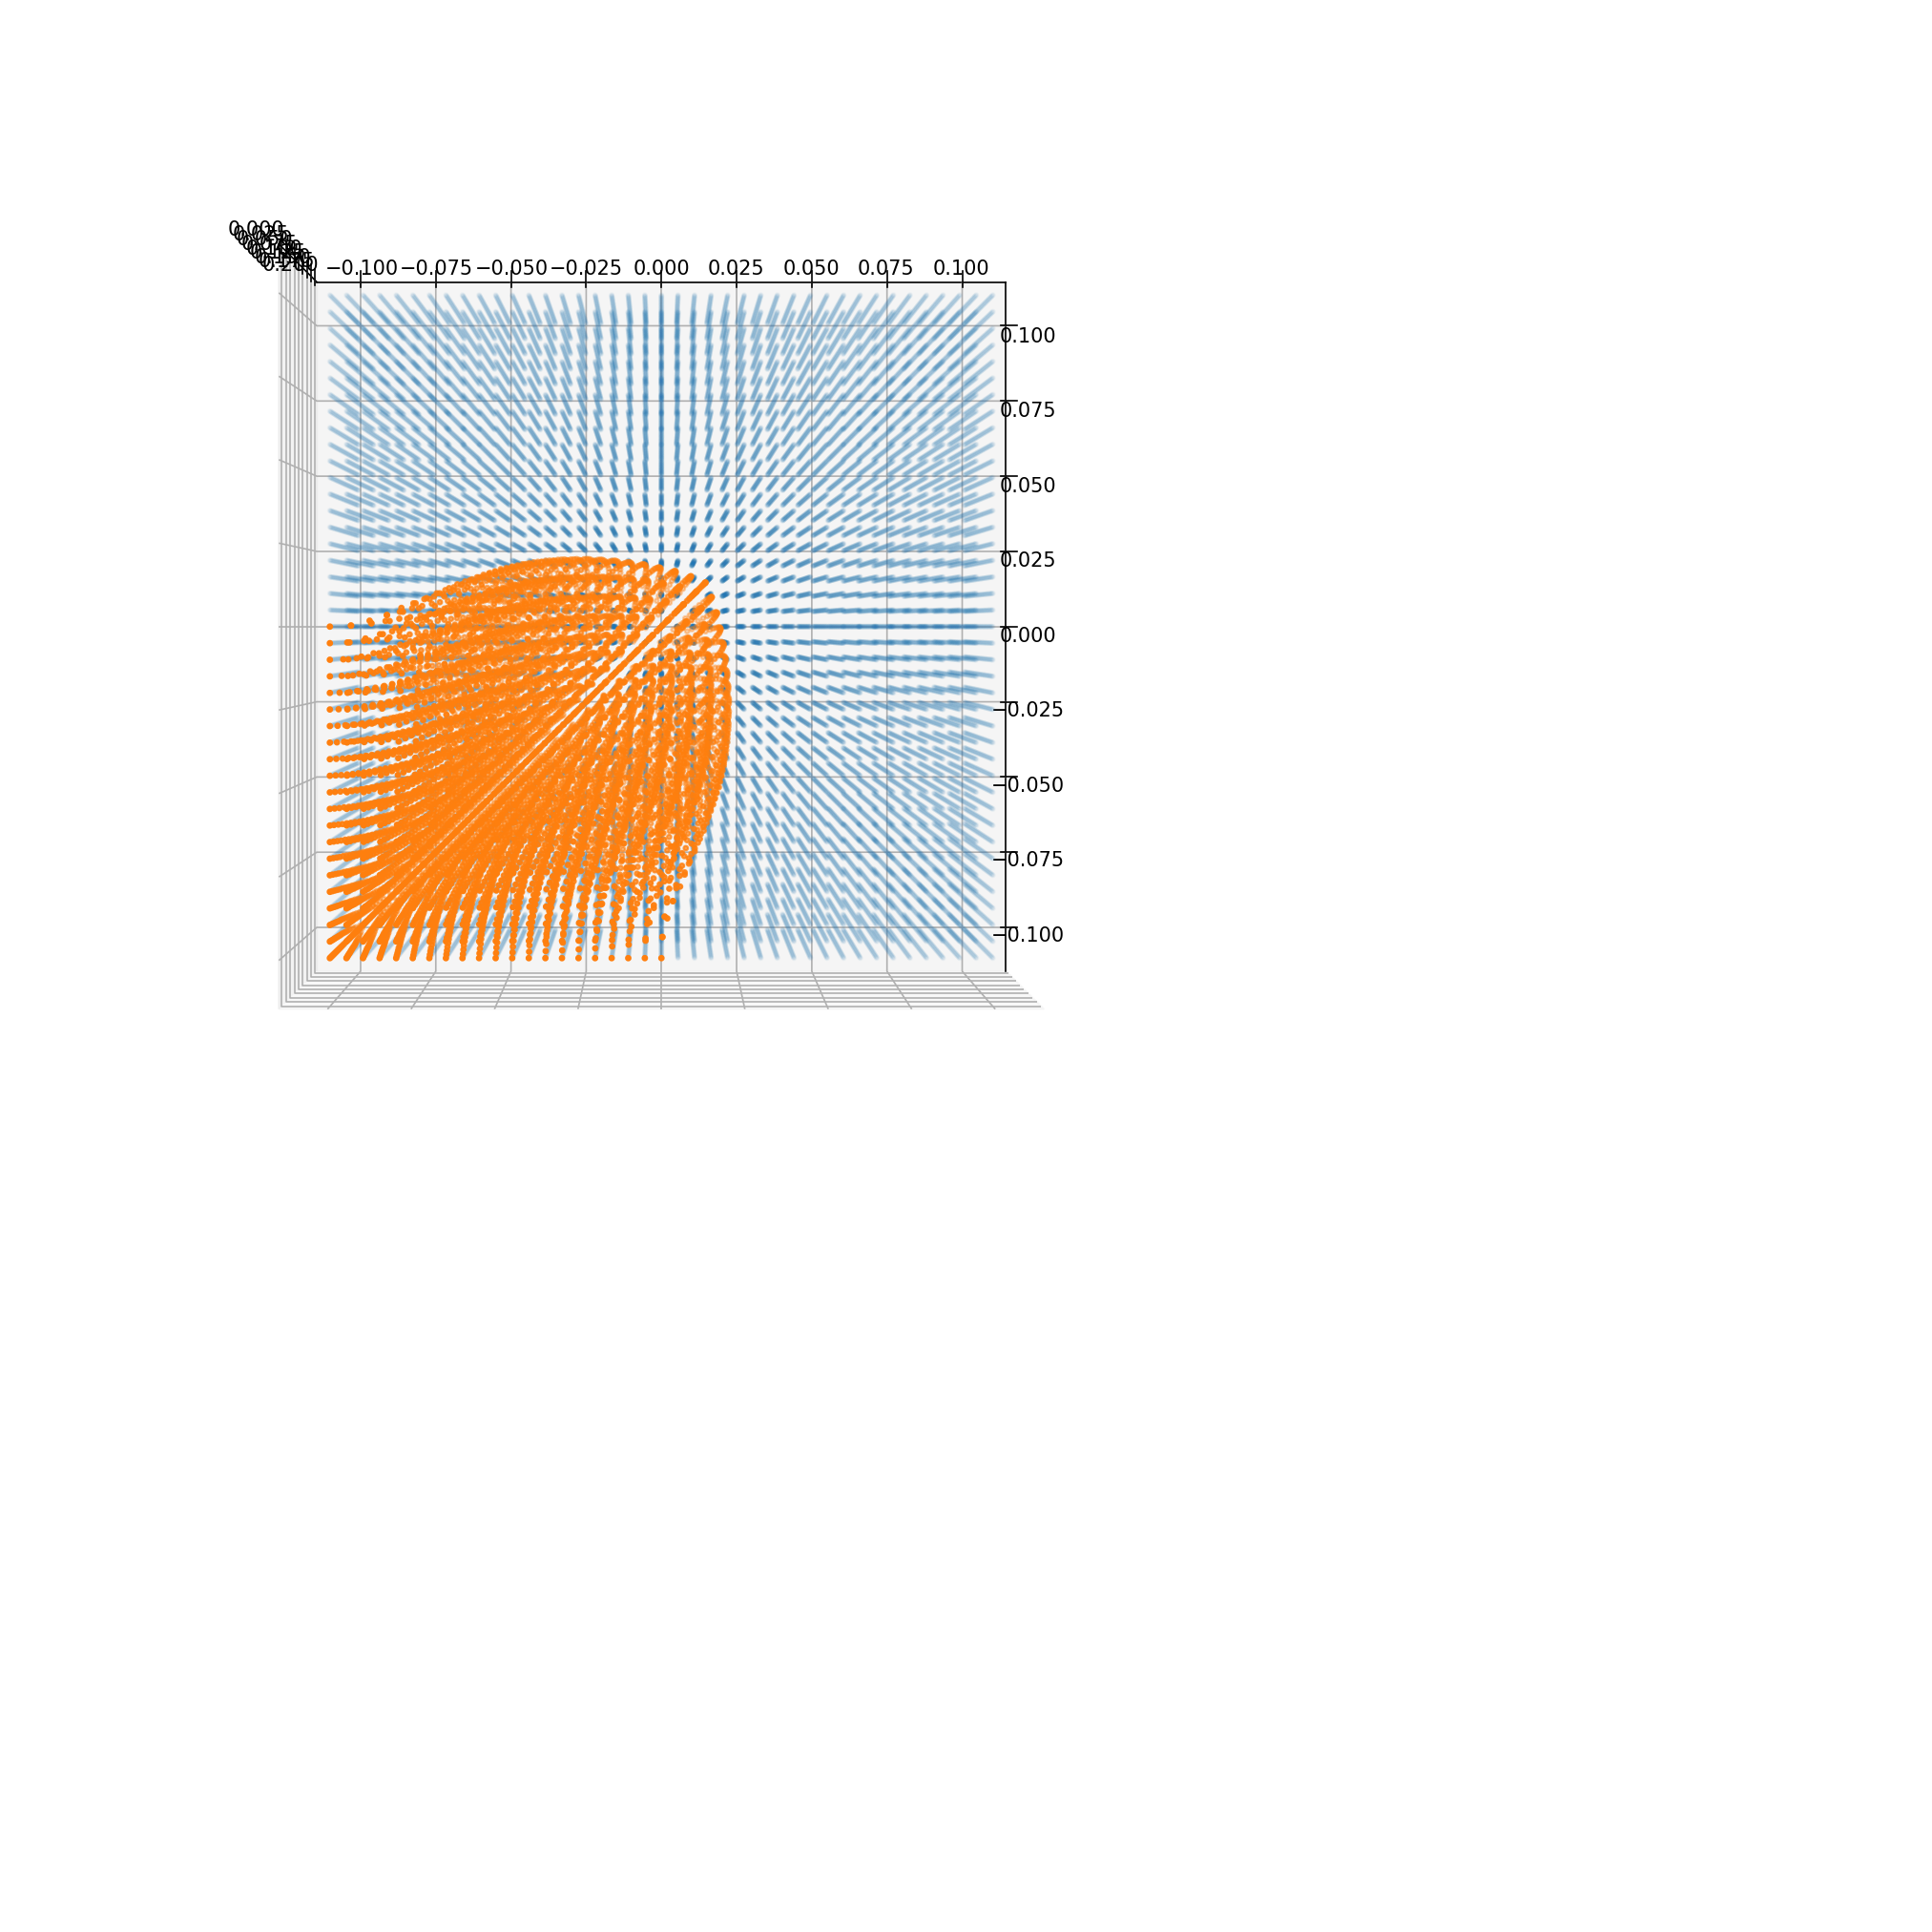

In [6]:
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook


fig = pyplot.figure(figsize=(9,9))
ax = Axes3D(fig)

x_arr1 = np.loadtxt('08species_1_x_00500.txt')
y_arr1 = np.loadtxt('08species_1_y_00500.txt')
z_arr1 = np.loadtxt('08species_1_z_00500.txt')

x_arr2 = np.loadtxt('08species_2_x_00500.txt')
y_arr2 = np.loadtxt('08species_2_y_00500.txt')
z_arr2 = np.loadtxt('08species_2_z_00500.txt')

ax.view_init(elev=-90., azim=0)
ax.scatter(x_arr1, y_arr1, z_arr1, s=3.5, alpha=0.05)
ax.scatter(x_arr2, y_arr2, z_arr2, s=5)
pyplot.show()